# Multivariate linear regression
using python package statsmodels

In [6]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import sys
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, str(Path.cwd().parent))
from src.utils import *

%load_ext autoreload

In [7]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Preparing Your Data: 
Make sure your data is in a suitable format. Typically, you'll have a pandas DataFrame with one column as the dependent variable (the outcome you're interested in predicting) and the other columns as independent variables (the predictors).

In [8]:
DATA_FOLDER = "../data/final/"
ihd_df = pd.read_csv(DATA_FOLDER + "gbd_IschemicHeartDisease_DeathsIncidence.csv")
ihd_df.rename(columns={'year': 'Year'}, inplace=True)
ihd_df = ihd_df[ihd_df['measure_name'] == 'Deaths']
ihd_df['Country Code'] = ihd_df['location_name'].apply(get_iso3_gbd)
ihd_df.head()

,measure_name,location_name,cause_name,Year,Value,upper,lower,Country Code
0,Deaths,Greece,Ischemic heart disease,1990,198.963673,206.809839,187.732342,GRC
1,Deaths,Lesotho,Ischemic heart disease,1990,38.577482,47.023134,29.860005,LSO
2,Deaths,Djibouti,Ischemic heart disease,1990,19.784015,25.606502,15.357142,DJI
3,Deaths,Global,Ischemic heart disease,1990,106.468267,110.197494,101.034486,GLB
4,Deaths,Chile,Ischemic heart disease,1990,82.872330,85.753086,78.615036,CHL


In [9]:
fat_df = pd.read_csv(DATA_FOLDER + "daily_per_capita_fat_supply_final.csv")
fat_df = fat_df[(fat_df['Year'] >= 1990) & (fat_df['Year'] <= 2019)]
fat_df.head()

,Country Name,Country Code,Series Name,Year,Value
29,Afghanistan,AFG,Fat consumption per day per capita (grams),1990,53.089370
30,Afghanistan,AFG,Fat consumption per day per capita (grams),1991,48.264060
31,Afghanistan,AFG,Fat consumption per day per capita (grams),1992,43.655660
32,Afghanistan,AFG,Fat consumption per day per capita (grams),1993,35.846720
33,Afghanistan,AFG,Fat consumption per day per capita (grams),1994,34.003414


In [10]:
# alcohol_df = pd.read_csv(DATA_FOLDER + "wdi_AlcoholConsumption.csv")
# alcohol_df = alcohol_df[alcohol_df["Country Name"] == "Germany"].copy()
# alcohol_df.head()
alcohol_df = pd.read_csv("../data/raw/alcohol_germany.csv")
alcohol_df = alcohol_df[(alcohol_df["TIME"] >= 1990) & (alcohol_df["TIME"] <= 2019)]
alcohol_df.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
30,AUS,ALCOHOL,TOT,LT_CAP15,A,1990,10.6,NaN
31,AUS,ALCOHOL,TOT,LT_CAP15,A,1991,10.1,NaN
32,AUS,ALCOHOL,TOT,LT_CAP15,A,1992,9.9,NaN
33,AUS,ALCOHOL,TOT,LT_CAP15,A,1993,10.2,NaN
34,AUS,ALCOHOL,TOT,LT_CAP15,A,1994,10.0,NaN


In [11]:
# smoking_df = pd.read_csv(DATA_FOLDER + "share-of-adults-who-smoke.csv")
# smoking_df = smoking_df[smoking_df["Entity"] == "Germany"].copy()
# smoking_df.head()
smoking_df = pd.read_csv("../data/raw/smoking_germany.csv")
smoking_df = smoking_df[(smoking_df["TIME"] >= 1990) & (smoking_df["TIME"] <= 2019)]
smoking_df

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
9,AUS,SMOKERS,TOT,PC_POP15,A,1992,26.0,NaN
10,AUS,SMOKERS,TOT,PC_POP15,A,1995,24.1,NaN
11,AUS,SMOKERS,TOT,PC_POP15,A,1998,22.1,NaN
12,AUS,SMOKERS,TOT,PC_POP15,A,2001,19.6,NaN
13,AUS,SMOKERS,TOT,PC_POP15,A,2004,17.8,NaN
...,...,...,...,...,...,...,...,...
895,HRV,SMOKERS,TOT,PC_POP15,A,2014,25.0,NaN
896,HRV,SMOKERS,TOT,PC_POP15,A,2019,22.1,NaN
897,ROU,SMOKERS,TOT,PC_POP15,A,2008,20.5,NaN
898,ROU,SMOKERS,TOT,PC_POP15,A,2014,19.8,NaN


In [12]:
healthSpending_df = pd.read_csv(DATA_FOLDER + "oecd_healthSpending_final.csv")
healthSpending_df = healthSpending_df[(healthSpending_df['Year'] >= 1990) & (healthSpending_df['Year'] <= 2019)]
healthSpending_df

,Country Name,Country Code,Series Name,Year,Value
19,Australia,AUS,HEALTHEXP,1990,1166.260
20,Australia,AUS,HEALTHEXP,1991,1234.372
21,Australia,AUS,HEALTHEXP,1992,1305.536
22,Australia,AUS,HEALTHEXP,1993,1373.205
23,Australia,AUS,HEALTHEXP,1994,1454.566
...,...,...,...,...,...
1731,Peru,PER,HEALTHEXP,2015,604.605
1732,Peru,PER,HEALTHEXP,2016,622.679
1733,Peru,PER,HEALTHEXP,2017,623.425
1734,Peru,PER,HEALTHEXP,2018,686.332


In [13]:
beds_df = pd.read_csv(DATA_FOLDER + "oecd_hospitalBeds_final.csv")
beds_df = beds_df[(beds_df['Year'] >= 1990) & (beds_df['Year'] <= 2019)]
beds_df

,Country Name,Country Code,Series Name,Year,Value
0,Australia,AUS,HOSPITALBED,1991,4.92
1,Australia,AUS,HOSPITALBED,1992,4.65
2,Australia,AUS,HOSPITALBED,1993,4.68
3,Australia,AUS,HOSPITALBED,1994,4.59
4,Australia,AUS,HOSPITALBED,1995,4.58
...,...,...,...,...,...
1190,Romania,ROU,HOSPITALBED,2015,6.79
1191,Romania,ROU,HOSPITALBED,2016,6.84
1192,Romania,ROU,HOSPITALBED,2017,6.89
1193,Romania,ROU,HOSPITALBED,2018,6.97


In [14]:
medianAge_df = pd.read_csv("../data/raw/median-age.csv")
medianAge_df = medianAge_df[(medianAge_df['Year'] >= 1990) & (medianAge_df['Year'] <= 2019)]
medianAge_df.drop(columns=['Median age - Sex: all - Age: all - Variant: medium'], inplace=True)
medianAge_df.rename(columns={'Median age - Sex: all - Age: all - Variant: estimates': 'Median Age'}, inplace=True)
medianAge_df

,Entity,Code,Year,Median Age
40,Afghanistan,AFG,1990,15.1
41,Afghanistan,AFG,1991,15.0
42,Afghanistan,AFG,1992,14.9
43,Afghanistan,AFG,1993,14.9
44,Afghanistan,AFG,1994,14.8
...,...,...,...,...
38419,Zimbabwe,ZWE,2015,17.0
38420,Zimbabwe,ZWE,2016,17.2
38421,Zimbabwe,ZWE,2017,17.3
38422,Zimbabwe,ZWE,2018,17.5


In [15]:
print(ihd_df['Country Code'].unique().shape)
print(fat_df['Country Code'].unique().shape)
print(alcohol_df['LOCATION'].unique().shape)
print(smoking_df['LOCATION'].unique().shape)
print(healthSpending_df['Country Code'].unique().shape)
print(beds_df['Country Code'].unique().shape)

(206,)
(195,)
(49,)
(49,)
(50,)
(47,)


In [16]:
def add_alcohol(combined_df):
    alcohol_df_renamed = alcohol_df.rename(columns={'Value': 'alcohol_consumption', "TIME": "Year", "LOCATION": "Country Code"})
    combined_df = combined_df.merge(alcohol_df_renamed[['alcohol_consumption', 'Year', 'Country Code']], on=['Year', 'Country Code'], how='left')
    return combined_df

def add_fat(combined_df):
    fat_df_renamed = fat_df.rename(columns={'Value': 'fat_consumption'})
    combined_df = combined_df.merge(fat_df_renamed[['fat_consumption', 'Year', 'Country Code']], on=['Country Code', 'Year'], how='left')
    return combined_df

def add_smoking(combined_df):
    smoking_df_renamed = smoking_df.rename(columns={'Value': 'daily_smokers', "TIME": "Year", "LOCATION": "Country Code"})
    combined_df = combined_df.merge(smoking_df_renamed[['daily_smokers', 'Year', 'Country Code']], on=['Year', 'Country Code'], how='left')
    return combined_df

def add_healthSpending(combined_df):
    healthSpending_df_renamed = healthSpending_df.rename(columns={'Value': 'health_spending'})
    combined_df = combined_df.merge(healthSpending_df_renamed[['health_spending', 'Year', 'Country Code']], on=['Year', 'Country Code'], how='left')
    return combined_df

def add_beds(combined_df):
    beds_df_renamed = beds_df.rename(columns={'Value': 'hospital_beds'})
    combined_df = combined_df.merge(beds_df_renamed[['hospital_beds', 'Year', 'Country Code']], on=['Year', 'Country Code'], how='left')
    return combined_df

def add_medianAge(combined_df):
    medianAge_df_renamed = medianAge_df.rename(columns={'Median Age': 'median_age', 'Code': 'Country Code'})
    combined_df = combined_df.merge(medianAge_df_renamed[['median_age', 'Year', 'Country Code']], on=['Year', 'Country Code'], how='left')
    return combined_df

In [18]:
country_codes = ['DEU', 'USA', 'GBR', 'JPN']

In [17]:
# aveage median age for all countries
avg_median_age = medianAge_df.groupby(['Entity', 'Code']).mean().reset_index()
avg_median_age.drop(columns=['Year'], inplace=True)
# print the sorted list of countries by median age
avg_median_age.sort_values(by=['Median Age'], ascending=False).head(20)


,Entity,Code,Median Age
229,Vatican,VAT,52.980000
138,Monaco,MCO,47.110000
105,Japan,JPN,42.260000
78,Germany,DEU,40.903333
103,Italy,ITA,40.806667
101,Isle of Man,IMN,40.360000
31,Bulgaria,BGR,39.703333
184,San Marino,SMR,39.533333
188,Serbia,SRB,39.410000
71,Finland,FIN,39.300000


In [19]:
combined_df = ihd_df[['Value', 'Year', 'Country Code']].copy()
# combined_df = combined_df[combined_df['Country Code'].isin(country_codes)]
combined_df.rename(columns={"Value":"incidence_rate"}, inplace=True)

independents = [add_medianAge, add_fat, add_alcohol, add_healthSpending]
for func in independents:
    combined_df = func(combined_df)  
    combined_df.dropna(inplace=True)
    print(combined_df.shape)
    
combined_df.dropna(inplace=True)
combined_df.drop(columns=['Year', 'Country Code'], inplace=True)
combined_df.reset_index(drop=True, inplace=True)
combined_df

(6120, 4)
(5031, 5)
(1424, 6)
(1115, 7)


,incidence_rate,median_age,fat_consumption,alcohol_consumption,health_spending
0,198.963673,35.0,136.877180,10.3,773.660
1,366.289575,35.6,125.342590,13.3,589.815
2,91.409508,36.9,82.114555,9.2,1088.959
3,129.563262,34.2,164.796830,15.4,1558.033
4,201.445701,29.0,123.757380,5.1,1575.185
...,...,...,...,...,...
1110,79.037449,32.0,135.499180,9.8,1497.734
1111,167.722435,46.0,151.993730,7.7,3565.324
1112,77.344261,31.5,102.603330,3.3,1529.721
1113,87.300176,30.0,88.557465,4.1,1239.660


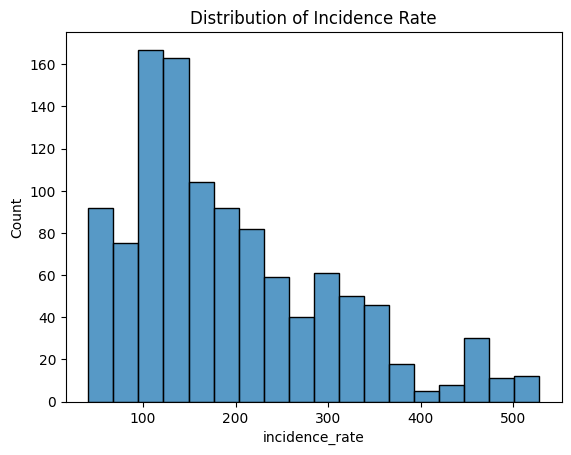

In [20]:
sns.histplot(combined_df['incidence_rate'])
plt.title('Distribution of Incidence Rate')
plt.show()

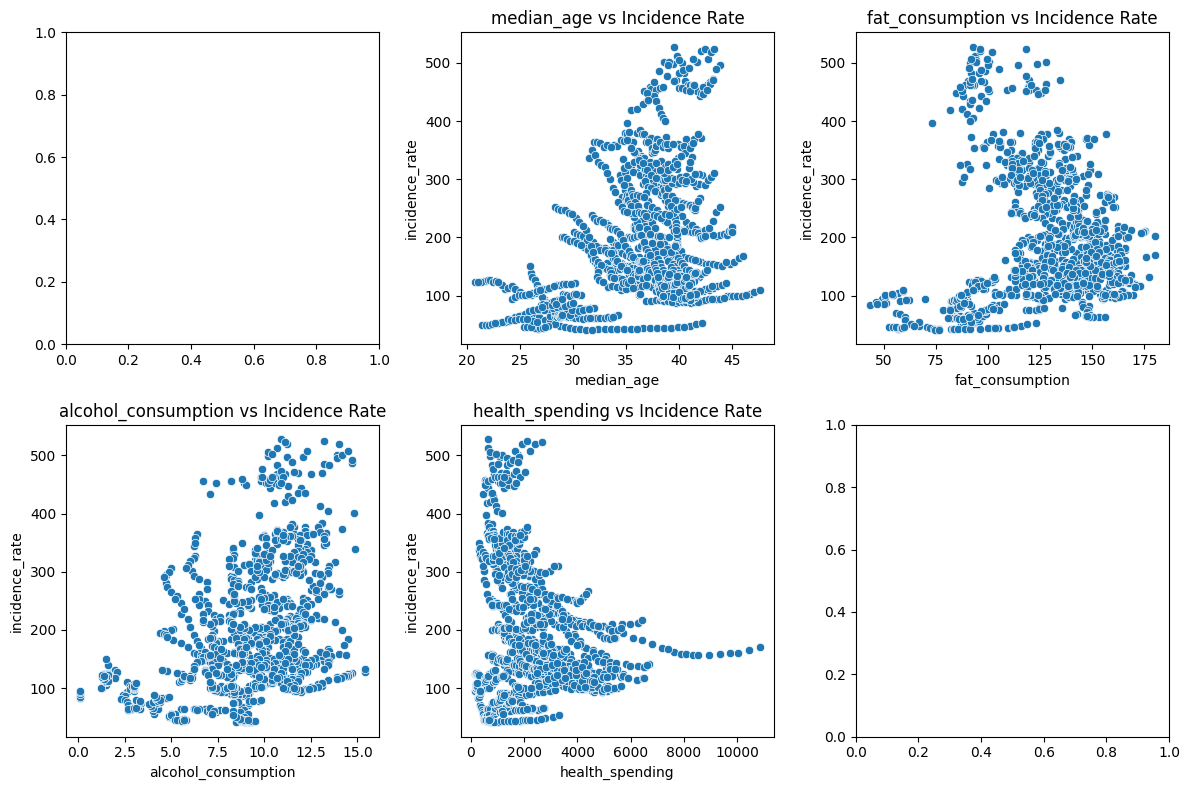

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, col_name in enumerate(combined_df.columns):
    if col_name == 'incidence_rate':
        continue
    row = i // 3
    col= i % 3
    ax = axes[row, col]
    sns.scatterplot(data=combined_df, x=col_name, y='incidence_rate', ax=ax)
    ax.set_title(f'{col_name} vs Incidence Rate')

plt.tight_layout()
plt.show()


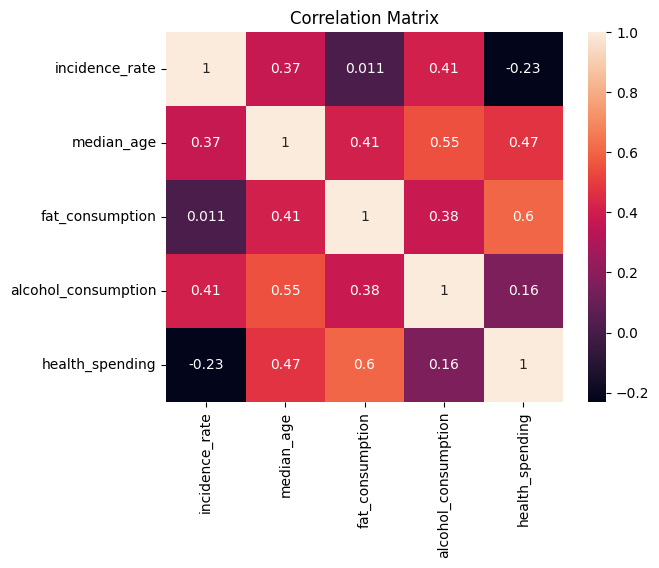

In [22]:
correlation_matrix = combined_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Prepare the data for modeling
X = combined_df.drop('incidence_rate', axis=1)  # independent variables
y = combined_df['incidence_rate']  # dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}')
print(f'R²: {r2}')


MSE: 8034.414383684875
R²: 0.38578312152674665


Best Random Forest MSE: 2367.480839967097
Best Random Forest R²: 0.8190102449379887


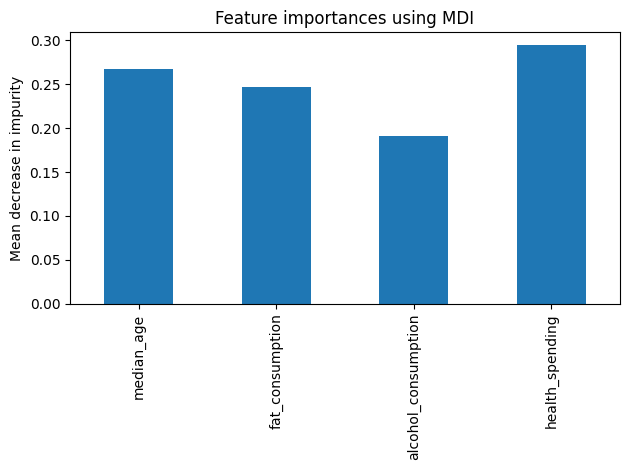

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Prepare the data for modeling
X = combined_df.drop('incidence_rate', axis=1)  # independent variables
y = combined_df['incidence_rate']  # dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define a grid of hyperparameters to search
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    # Add other parameters here
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict and evaluate using the best model
rf_pred = best_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

# Output results
print(f'Best Random Forest MSE: {rf_mse}')
print(f'Best Random Forest R²: {rf_r2}')

# Feature importances
importances = best_model.named_steps['rf'].feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


Shape of shap_values_instance: (4,)


IndexError: tuple index out of range

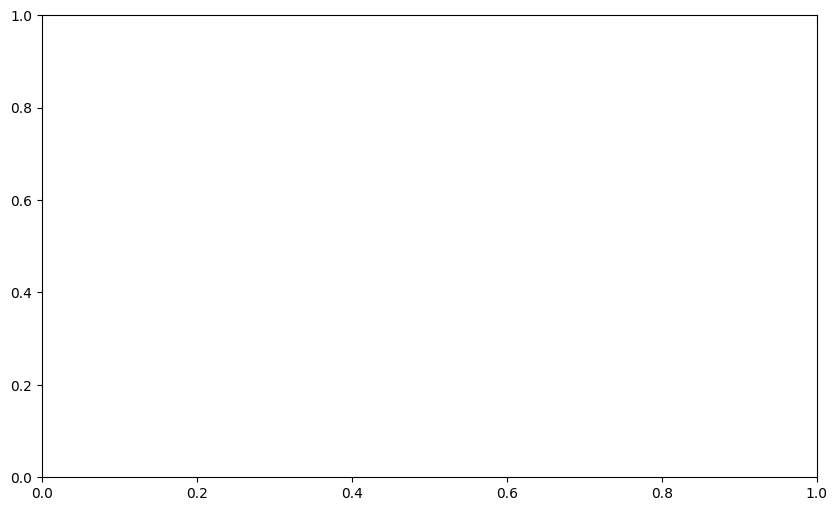

In [51]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Create the SHAP explainer with the Random Forest model
explainer = shap.Explainer(best_model.named_steps['rf'], X_train, 
                           feature_names=feature_names.to_list(), check_additivity=False)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Select a specific instance (e.g., the first instance)
instance_index = 0
shap_values_instance = shap_values[instance_index]
print("Shape of shap_values_instance:", shap_values_instance.shape)


# Create a bar plot to visualize SHAP values for all features
plt.figure(figsize=(10, 6))
plt.barh(range(len(shap_values_instance)), shap_values_instance, color='blue')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('SHAP Value')
plt.title(f'SHAP Values for Instance {instance_index}')
plt.show()
